In [132]:
from openpyxl import Workbook
from openpyxl import load_workbook
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [133]:
directory_in_str = "C:\\Users\\Edward\\OneDrive\\Documents\\University\\Fourth Year\\Thesis\\Papers\\ExcelDataCollection\\Complete\\"
#print(directory_in_str)
directory = os.fsencode(directory_in_str)

COLUMN_NAMES=['TotalT','Temp','LSR','CA','Size','Mass','Moisture', 'IsoT', 'HeatT', 'Ramp', 'F_A', 'F_Gal', 'F_Glu',
            'F_X', 'F_M', 'F_R', 'A', 'Gal', 'Glu','X', 'M', 'R', 'Furf', 'HMF', 'Source']

masterDF = pd.DataFrame(columns=COLUMN_NAMES)
#print(len(masterDF.columns))
#print(masterDF.columns)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    absPath = directory_in_str + filename
    if filename.endswith(".xlsx"): 
        wb = load_workbook(filename = absPath, data_only = True) 
        ws = wb["Data"]
        ws.delete_rows(1,2)
        df = pd.DataFrame(ws.values, columns=COLUMN_NAMES[:-1])
        df['Source'] = filename
        #print("1", df.at[1, 'Temp'])
        masterDF = pd.concat([masterDF, df], ignore_index=True)
        #masterDF = masterDF.append(df)
        #print("2",masterDF.at[1, 'Temp'])
        continue
    else:
        continue
        
#masterDF = masterDF.astype(float)
masterDF.reset_index()


for i in masterDF.index:
    if masterDF.at[i, 'Ramp'] is None or pd.isnull(masterDF.at[i, 'Ramp']):
        masterDF.at[i, 'Ramp'] = (masterDF.at[i, 'Temp'] - 25) / masterDF.at[i, 'HeatT']
    if masterDF.at[i, 'HeatT'] is None or pd.isnull(masterDF.at[i, 'HeatT']):
        masterDF.at[i, 'HeatT'] = (masterDF.at[i, 'Temp'] - 25) / masterDF.at[i, 'Ramp']
    #print(type(masterDF.at[i, 'TotalT']))
    #print((masterDF.at[i, 'Temp']))
    if masterDF.at[i, 'TotalT'] is None or pd.isnull(masterDF.at[i, 'TotalT']):
        masterDF.at[i, 'TotalT'] =  masterDF.at[i, 'HeatT'] +  masterDF.at[i, 'IsoT']
    if masterDF.at[i, 'IsoT'] is None or pd.isnull(masterDF.at[i, 'IsoT']):
        masterDF.at[i, 'IsoT'] =  masterDF.at[i, 'TotalT'] -  masterDF.at[i, 'HeatT']
    if masterDF.at[i, 'TotalT'] == 0:
        masterDF.at[i, 'IsoT'] =  0
        masterDF.at[i, 'HeatT'] =  0
        
masterDF['TotalT'].fillna(masterDF.at[i, 'HeatT'] +  masterDF.at[i, 'IsoT'])


        
masterDF['X'].fillna(0, inplace=True)
#Converting Celsius to Kelvin

masterDF['Temp'] = masterDF['Temp'] + 273.15

#This makes everything numeric
masterDF.to_csv("data.csv", index=False)
masterDF = pd.read_csv("data.csv")


#Creating Yield, Ro and P Factor
masterDF['Yield'] = 100 * masterDF['X'] * masterDF['LSR'] / (1000 * (masterDF['F_X']/100)) #1000 is density of water in g/L, X is in g/L

#P = exp(40.48 - 15106/T) * t, with T in Kelvin, t in hours
masterDF['P'] = np.exp(40.48 - 15106/masterDF['Temp']) * masterDF['IsoT']/60
masterDF['logP'] = masterDF['P']

#Ro = t * exp((T - 100)/14.75), t in minutes, T in Celsius
masterDF['Ro'] = masterDF['IsoT'] * np.exp(((masterDF['Temp'] -273.15) - 100)/14.75)
masterDF['logRo'] = masterDF['Ro']

for i in masterDF.index:
    if masterDF.at[i, 'logRo'] != 0:
        masterDF.at[i, 'logRo'] = np.log( masterDF.at[i, 'logRo'])
    if masterDF.at[i, 'logP'] != 0:
        masterDF.at[i, 'logP'] = np.log( masterDF.at[i, 'logP'])

masterDF.to_csv("data.csv", index=False)



(784, 30)


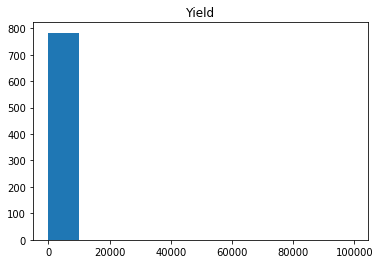

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

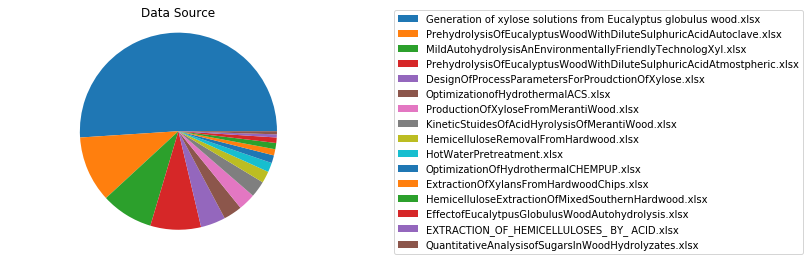

In [134]:
import matplotlib.patches

#Plotting Data
data = pd.read_csv("data.csv")
##Making new columns



X = data[['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X']]
Y = data['X']

# print(data.head())
print(data.shape)
# print(data['Yield'].max())
#print(data['Yield'])

if None in data['Yield']:
    print(True)

#Plotting
fYield = plt.figure()
fTempvYield = plt.figure()
fAcidVYield = plt.figure()
fRoVYield = plt.figure()
fPVYield = plt.figure()
fDataSource = plt.figure()

axYield = fYield.add_subplot(111)
axYield.hist(data['Yield'])
axYield.set_title("Yield")


# axTempVYield = fTempvYield.add_subplot(111)
# axTempVYield.scatter(data['Temp'], data['Yield'])
# axTempVYield.set_title("Temp vs Yield")

# axAcidVYield = fAcidVYield.add_subplot(111)
# axAcidVYield.scatter(data['CA'], data['Yield'])
# axAcidVYield.set_title("Acid vs Yield")

# axRoVYield = fRoVYield.add_subplot(111)
# axRoVYield.scatter(data['logRo'], data['Yield'])
# axRoVYield.set_title("logRo vs Yield")

# axPVYield = fPVYield.add_subplot(111)
# axPVYield.scatter(data['logP'], data['Yield'])
# axPVYield.set_title("logP vs Yield")

sourceFreq = pd.value_counts(data['Source'])


axDataSource = fDataSource.add_subplot(111)
axDataSource.pie(sourceFreq.values)
axDataSource.set_title("Data Source")
axDataSource.axis('equal')
labels = sourceFreq.axes[0]
# handles = []
# for i, l in enumerate(labels):
#     handles.append(matplotlib.patches.Patch(color=plt.cm.Set3((i)/8.), label=l))
# axDataSource.legend(handles,labels, bbox_to_anchor=(0.85,1.025), loc="upper left")

axDataSource.legend(labels, bbox_to_anchor=(1,0.5), loc=6, fontsize=10, 
           bbox_transform=plt.gcf().transFigure)


plt.show()

print()


In [144]:
#Prepping Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


data = data.sample(frac=1).reset_index(drop=True)
XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P']
X = data[XLabels]
# y = data['Yield']

#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)  

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

# print(len(X_train), len(X_test), len(X_valid))
# print(X_train)

# plt.hist(y_train)

numData = len(data.index)
numTrain = int(numData * 0.7)
numTest = int(numData * .15) 
# print(numTest, numTrain)
train_Frame, valid_frame, test_frame = data.iloc[:numTrain, :], data.iloc[numTrain:-numTest, :], data.iloc[-numTest:, :]

y_train, y_valid, y_test = train_Frame['Yield'], valid_frame['Yield'], test_frame['Yield']

X_train, X_valid, X_test = X[:numTrain, :], X[numTrain:-numTest, :], X[-numTest:, :]


In [136]:
# ##PCA
# from sklearn.decomposition import PCA


# pca = PCA()
# principalComponents = pca.fit_transform(X)

# #print(principalComponents)


# #print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
# labels = np.arange(1, len(pca.explained_variance_ratio_) + 1)

# #plt.bar(labels, pca.explained_variance_ratio_)

# fSpectral = plt.figure()
# fCumSpectral = plt.figure()
# fPCA = plt.figure()


# axSpectral = fSpectral.add_subplot(111)
# axSpectral.bar(labels, pca.explained_variance_ratio_)
# axSpectral.set_title("Spectral")


# axCumSpectral = fCumSpectral.add_subplot(111)
# axCumSpectral.bar(labels, np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
# axCumSpectral.set_title("Cumulative Variance")

# temp = (principalComponents[:2])

# principalDf = pd.DataFrame(data = principalComponents)
# # for column in principalDf.columns:
# #     df.rename(columns={column, "PC" + str(column)}, inplace=True)

# finalDf = pd.concat([principalDf, data[['Yield']]], axis = 1)
# targets = ["0 to 20", "20 to 40", "40 to 60", "60 to 80", "80 to 100"]
# colors = ['r', 'g', 'b','y', 'm']


# finalDf['binnedYield'] = None
# for i in finalDf.index:
#     if 0< finalDf.at[i, 'Yield']  <= 20:
#         finalDf.at[i, 'binnedYield'] = targets[0]
#     elif 0< finalDf.at[i, 'Yield'] <= 40:
#         finalDf.at[i,'binnedYield'] = targets[1]
#     elif 0< finalDf.at[i,'Yield']  <= 60:
#         finalDf.at[i,'binnedYield'] = targets[2]
#     elif 0< finalDf.at[i,'Yield'] <= 80:
#         finalDf.at[i,'binnedYield'] = targets[3]
#     elif 0< finalDf.at[i, 'Yield'] <= 100:
#         finalDf.at[i,'binnedYield'] = targets[4]


# # print(finalDf.head())

# axPCA = fPCA.add_subplot(111)
# axPCA.set_xlabel('Principal Component 1', fontsize = 15)
# axPCA.set_ylabel('Principal Component 2', fontsize = 15)
# axPCA.set_title('2 component PCA', fontsize = 20)
# # axPCA.scatter(finalDf.iloc[:,0]
# #                , finalDf.iloc[:,1])


# for target, color in zip(targets,colors):
#     indicesToKeep = finalDf['binnedYield'] == target
#     axPCA.scatter(finalDf.loc[indicesToKeep, 0]
#                , finalDf.loc[indicesToKeep, 1]
#                , c = color
#                , s = 50)
# axPCA.legend(targets)
# axPCA.grid()

# # targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
# # colors = ['r', 'g', 'b']

# # for target, color in zip(targets,colors):
# #     indicesToKeep = finalDf['target'] == target
# #     ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
# #                , finalDf.loc[indicesToKeep, 'principal component 2']
# #                , c = color
# #                , s = 50)
# # ax.legend(targets)
# # ax.grid()


# plt.show()




# #print(finalDf.iloc[:,0])

# finalDf.to_csv("PCA.csv")


<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
average 50.260943839982566
Mean Absolute Error: 12.88737281431688
Mean Squared Error: 274.7416296537305
Root Mean Squared Error: 16.575331962097486


(-10.533503274191396, 94.57471264367818)

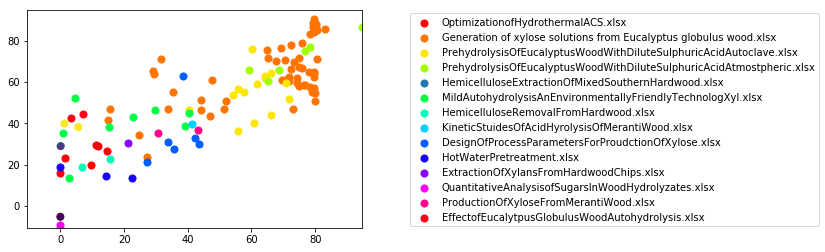

In [147]:
#Multiple Linear Regression Simple
from sklearn import linear_model
import statsmodels.api as sm
from sklearn import metrics

# with sklearn

# print(type(X_train))
# np.savetxt("temp.csv", X_train)
print(type(X_train), type(y_train))


# print(np.isnan(X_train))
np.argwhere(np.isnan(X_train))
#print(X_train)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

coeffs = dict(zip(XLabels, regr.coef_))

# print("results of SKLearnLinearRegression----------------")
# print('Intercept: \n', regr.intercept_)
# print('Coefficients: \n', coeffs)
# print('Score', regr.score(X,Y))
y_pred = regr.predict(X_test)



print('average', y_test.mean())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print("Coefficients: ", best_model.coef_)

error_arr = abs(y_test - y_pred)
#plt.hist(error_arr)
#plt.scatter(y_test, y_pred)


targets = test_frame['Source'].unique()
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

colors = get_cmap(len(targets))

for index, target in enumerate(targets):
    indicesToKeep = test_frame['Source'] == target
    plt.scatter(y_test.values[indicesToKeep]
               , y_pred[indicesToKeep]
               , c = colors(index)
               , s = 50)
plt.legend(targets, bbox_to_anchor=(1,0.5), loc=6, fontsize=10, 
           bbox_transform=plt.gcf().transFigure)


plt.ylim(np.min((np.min([np.min(y_test), np.min(y_pred)]))), np.max((np.max([np.max(y_test), np.max(y_pred)]))))
plt.xlim(np.min((np.min([np.min(y_test), np.min(y_pred)]))), np.max((np.max([np.max(y_test), np.max(y_pred)]))))

best alpha is:  100
Lowest Error In Validation _MSE_  82993735.40045488
average 50.260943839982566
Mean Absolute Error: 13.794062160982593
Mean Squared Error: 328.7059240153462
Root Mean Squared Error: 18.13024886799258
Coefficients:  [  0.97524877 -12.69577354   1.20647235   4.93061468   2.36382545
   4.27379346   2.21392161  -5.71131655  -1.61080196  -4.01967162
  -1.81259998   7.42100991  -1.15213589]


(0.0, 94.57471264367818)

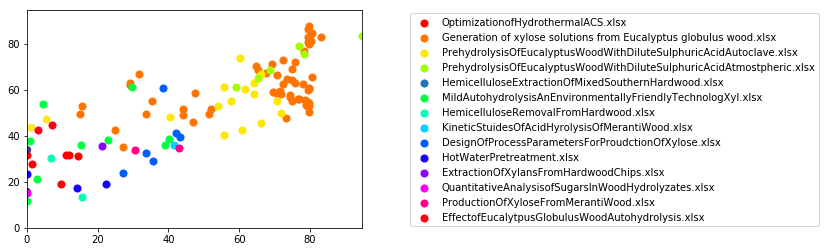

In [148]:
#Linear Least Square with I2 regularization
#Ridge
from sklearn.linear_model import Ridge
from sklearn import metrics


alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100]
errors = []

#Creating Different models for different alphas
for a in alphas:
    ridgeModel = Ridge(alpha=a)
    ridgeModel.fit(X_train, y_train) 
    y_pred = ridgeModel.predict(X_valid)
    error =  metrics.mean_squared_error(y_valid, y_pred)
    errors.append(error)
    

best_alpha = alphas[np.argmin(errors)]
print("best alpha is: ",best_alpha)
print("Lowest Error In Validation _MSE_ ", np.min(errors))

best_model = Ridge(alpha=best_alpha)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

    
#Evaluation
print('average', y_test.mean())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Coefficients: ", best_model.coef_)

error_arr = abs(y_test - y_pred)
#plt.hist(error_arr)
#plt.scatter(y_test, y_pred)

targets = test_frame['Source'].unique()
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

colors = get_cmap(len(targets))

for index, target in enumerate(targets):
    indicesToKeep = test_frame['Source'] == target
    plt.scatter(y_test.values[indicesToKeep]
               , y_pred[indicesToKeep]
               , c = colors(index)
               , s = 50)
plt.legend(targets, bbox_to_anchor=(1,0.5), loc=6, fontsize=10, 
           bbox_transform=plt.gcf().transFigure)


plt.ylim(np.min((np.min([np.min(y_test), np.min(y_pred)]))), np.max((np.max([np.max(y_test), np.max(y_pred)]))))
plt.xlim(np.min((np.min([np.min(y_test), np.min(y_pred)]))), np.max((np.max([np.max(y_test), np.max(y_pred)]))))


average 50.260943839982566
Mean Absolute Error: 4.0930335232904715
Mean Squared Error: 56.09017879856334
Root Mean Squared Error: 7.489337674224827


(-3.377774368458809, 94.57471264367818)

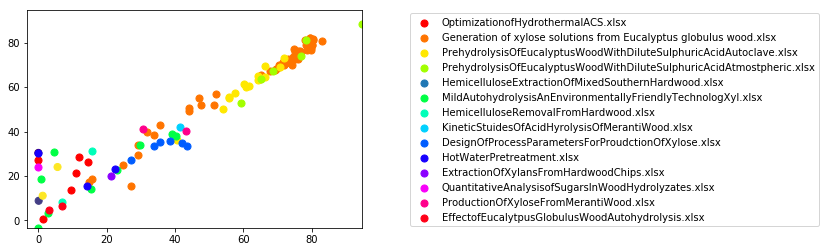

In [149]:
#SVM Models
from sklearn.svm import SVR


kernels =  ['linear', 'poly', 'rbf', 'sigmoid']
gammas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
Cs =[0.1, 0.5, 1, 5, 10, 50, 100]
#Cs =[0.1, 0.5, 1]
errors = []

# for kern in kernels:
#     for gam in gammas:
#         for C_ in Cs:
#             svrModel = SVR(kernel=kern, gamma=gam, cache_size=1000, C=C_)
#             svrModel.fit(X_train, y_train) 
#             y_pred = svrModel.predict(X_valid)
#             error =  metrics.mean_squared_error(y_valid, y_pred)
#             errors.append(error)
        
        
#For 2D
# index_of_lowest_error = np.argmin(errors)
# print("Lowest Error In Validation _MSE_ ", np.min(errors))

# best_kernel = kernels[int(index_of_lowest_error / len(gammas))]
# best_gamma = gammas[index_of_lowest_error % len(gammas)]
# print("Best kernel is: ", best_kernel)
# print("Best Gamma is: ", best_gamma)

#For3d -------------------------------------------

# index_of_lowest_error = np.argmin(errors)
# print("Lowest Error In Validation _MSE_ ", np.min(errors))

# best_kernel = kernels[int(index_of_lowest_error / (len(gammas) * len(Cs)))] #Good
# best_gamma = gammas[int((index_of_lowest_error % (len(gammas) * len(Cs)))/len(Cs))] #Good
# best_C = Cs[index_of_lowest_error % len(Cs)] #Good 
# print("Best kernel is: ", best_kernel)
# print("Best Gamma is: ", best_gamma)
#print("Best C is: ", best_C)

#Make it run a little faster, hardcode best
best_kernel = 'rbf'
best_gamma = 0.5
best_C = 100

best_model = SVR(kernel=best_kernel, gamma=best_gamma, cache_size=2000, C=best_C)
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)


print('average', y_test.mean())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

error_arr = abs(y_test - y_pred)
#plt.hist(error_arr)
#plt.scatter(y_test, y_pred)

targets = test_frame['Source'].unique()
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

colors = get_cmap(len(targets))

for index, target in enumerate(targets):
    indicesToKeep = test_frame['Source'] == target
    plt.scatter(y_test.values[indicesToKeep]
               , y_pred[indicesToKeep]
               , c = colors(index)
               , s = 50)
plt.legend(targets, bbox_to_anchor=(1,0.5), loc=6, fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

plt.ylim(np.min((np.min([np.min(y_test), np.min(y_pred)]))), np.max((np.max([np.max(y_test), np.max(y_pred)]))))
plt.xlim(np.min((np.min([np.min(y_test), np.min(y_pred)]))), np.max((np.max([np.max(y_test), np.max(y_pred)]))))
# vectors = np.asarray(best_model.support_vectors_)
# print(vectors.shape)
# print(vectors)

In [142]:
# #Keras
# from keras.models import Sequential
# from keras.layers import Dense

# model = Sequential()

# model.add(Dense(units=4, activation='relu', input_dim=14))
# model.add(Dense(units=1, activation='softmax'))

# model.compile(loss='mean_squared_error',
#               optimizer='sgd',
#               metrics=['accuracy'])

# print(len(X_train), len(y_train))
# print(len(X_test), len(y_test))

# model.fit(X_train, y_train, epochs=40, batch_size=32)

# loss_and_metrics = model.evaluate(X_test, y_test, batch_size=128)
                                  
# classes = model.predict(X_test, batch_size=128)

